# **Using Pre-trained Models in PyTorch to get Rank-1 and Rank-5 Accuracy**
1. We'll first load the pre-trained ImageNet model VGG16
2. We'll get the top 5 classes from a single image inference
3. Next we'll construct a function to give us the rank-N Accuracy using a few test images

---


In [143]:
# Load our pre-trained VGG16
import torchvision.models as models
from torchsummary import summary
import torch
import json
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as nnf
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(pretrained=True)
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## **Normalisation**

All pre-trained models expect input images **normalized** in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:

`normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])`

In [144]:
from torchvision import datasets, transforms, models

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG16 normalization
])

In [145]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Download our ImageNet Class Name and our Test Images

In [146]:
# !wget https://raw.githubusercontent.com/rajeevratan84/ModernComputerVision/main/imageNetclasses.json

In [147]:
# ! unzip /content/images.zip

In [148]:
# ! rm -f /content/images/class1/.DS_Store

In [149]:
with open("/content/imageNetclasses.json") as f:
  class_names=json.load(f)

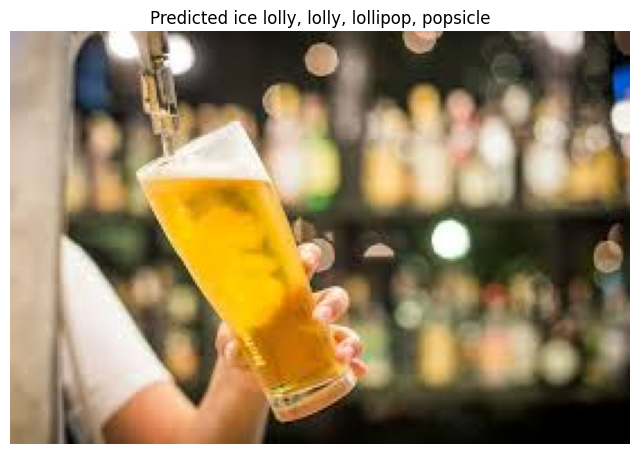

In [150]:
from PIL import Image
import numpy as np

image = Image.open('/content/images/class1/beer glass.jpg')

# Convert to Tensor
image_tensor = test_transforms(image).float()
image_tensor = image_tensor.unsqueeze_(0)
input = Variable(image_tensor)
input = input.to(device)
output = model(input)
index = output.data.cpu().numpy().argmax()
name = class_names[str(index)]

# Plot image
fig=plt.figure(figsize=(8,8))
plt.axis('off')
plt.title(f'Predicted {name}')
plt.imshow(image)
plt.show()

# Get our Class Probabilities

In [151]:
import torch.nn.functional as nnf

prob = nnf.softmax(output, dim=1)

top_p, top_class = prob.topk(5, dim = 1)
print(top_p, top_class)

tensor([[0.2247, 0.0788, 0.0655, 0.0495, 0.0396]], grad_fn=<TopkBackward0>) tensor([[929, 862, 728, 441, 696]])


In [152]:
# Convert to numpy array
top_class_np = top_class.cpu().data.numpy()[0]
top_class_np

array([929, 862, 728, 441, 696])

# Create a class that gives us our class names

In [153]:
def getClassNames(top_classes):
  top_classes = top_classes.cpu().data.numpy()[0]
  all_classes = []
  for top_class in top_classes:
    all_classes.append(class_names[str(top_class)])
  return all_classes

In [154]:
getClassNames(top_class)

['ice lolly, lolly, lollipop, popsicle',
 'torch',
 'plastic bag',
 'beer glass',
 'paintbrush']

# Construct our function to give us our Rank-N Accuracy

In [155]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from PIL import Image  # Missing import
import torch  # Missing import
from torch.autograd import Variable  # Missing import
import torch.nn.functional as nnf  # Missing import

fig = plt.figure(figsize=(16, 16))

def getRankN(model, directory, ground_truth, N, show_images=True):
    # Get image names in directory
    onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]

    # We'll store the top-N class names here
    all_top_classes = []

    # Iterate through our test images
    for (i, image_filename) in enumerate(onlyfiles):
        # Use string concatenation with a slash (better to use os.path.join)
        image = Image.open(directory + "/" + image_filename)  # Works, but os.path.join is safer

        # Convert to Tensor
        image_tensor = test_transforms(image).float()  # test_transforms must be defined
        image_tensor = image_tensor.unsqueeze_(0)
        input = Variable(image_tensor)  # Variable is deprecated in newer PyTorch; unnecessary here
        input = input.to(device)  # device must be defined
        output = model(input)  # model must be defined
        # Get probabilities and top-N class names
        prob = nnf.softmax(output, dim=1)
        top_p, top_class = prob.topk(N, dim=1)
        top_class_names = getClassNames(top_class)  # getClassNames must be defined
        all_top_classes.append(top_class_names)

        if show_images:
            # Plot image
            sub = fig.add_subplot(len(onlyfiles), 1, i + 1)
            x = ", ".join(top_class_names)
            print(f'Top {N} Predicted Classes: {x}')
            plt.axis('off')
            plt.imshow(image)
            plt.show()  # This displays each image separately, breaking the grid

    # Move plt.show() outside the loop for a single figure
    plt.show()
    return getScore(all_top_classes, ground_truth, N)



def getScore(all_top_classes, ground_truth, N):
    in_labels = 0
    for i, labels in enumerate(all_top_classes):
        gt_labels = ground_truth[i].split(', ')  # Split ground truth into possible class names
        print(f"Ground Truth {i}: {gt_labels}")  # Print expected label
        print(f"Predicted {i}: {labels}")  # Print model's prediction

        if any(gt.lower() in label.lower() for gt in gt_labels for label in labels):
            in_labels += 1  # Increment if any synonym matches

    accuracy = (in_labels / len(all_top_classes)) * 100
    return f'Rank-{N} Accuracy = {accuracy:.2f}%'





<Figure size 1600x1600 with 0 Axes>

In [156]:
ground_truth = [
    'collie',                         # long-haired-collie-5766447_1280.jpg
    'limousine, limo',                 # limo-safety-ftr.jpg
    'spider web, spider\'s web',       # spiderweb_1050x700.jpg
    'burrito',                         # barrito.jpg
    'basketball',                      # Basketball_(Ball).jpg
    'german shepherd, german shepherd dog, german police dog, alsatian',  # German_Shepherd_-_DSC_0346_(10096362833).jpg
    'beer_glass',                      # beer glass.jpg
    'christmas stocking',              # christmas-stockings-3006869_1280.jpg
    'doormat, welcome mat'             # doormat.jpg
]


In [157]:
from os import listdir
from os.path import isfile, join
import os

# Define the directory where your images are located
directory = '/content/images/class1'  # Replace with your actual image directory path

# Get image names in directory
onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]

# Now you can loop through the images and print ground truth
for i, image_filename in enumerate(onlyfiles):
    print(f"Image {i}: {image_filename}")
    print(f"Ground Truth: {ground_truth[i]}")



Image 0: long-haired-collie-5766447_1280.jpg
Ground Truth: collie
Image 1: limo-safety-ftr.jpg
Ground Truth: limousine, limo
Image 2: spiderweb_1050x700.jpg
Ground Truth: spider web, spider's web
Image 3: barrito.jpg
Ground Truth: burrito
Image 4: Basketball_(Ball).jpg
Ground Truth: basketball
Image 5: German_Shepherd_-_DSC_0346_(10096362833).jpg
Ground Truth: german shepherd, german shepherd dog, german police dog, alsatian
Image 6: beer glass.jpg
Ground Truth: beer_glass
Image 7: christmas-stockings-3006869_1280.jpg
Ground Truth: christmas stocking
Image 8: doormat.jpg
Ground Truth: doormat, welcome mat


In [158]:

print(os.listdir(directory))


['long-haired-collie-5766447_1280.jpg', 'limo-safety-ftr.jpg', 'spiderweb_1050x700.jpg', 'barrito.jpg', 'Basketball_(Ball).jpg', 'German_Shepherd_-_DSC_0346_(10096362833).jpg', 'beer glass.jpg', 'christmas-stockings-3006869_1280.jpg', 'doormat.jpg', '.ipynb_checkpoints']


# Get Rank-5 Accuracy

Top 5 Predicted Classes: collie, Shetland sheepdog, Shetland sheep dog, Shetland, papillon, Border collie, Pomeranian


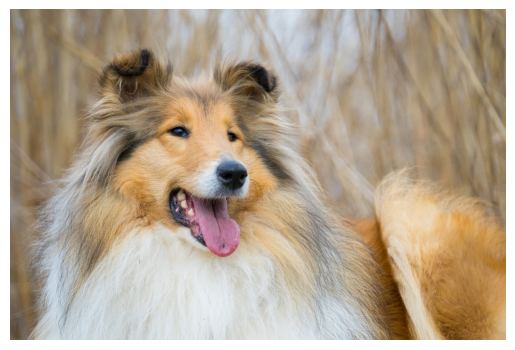

Top 5 Predicted Classes: limousine, limo, minivan, convertible, grille, radiator grille, beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon


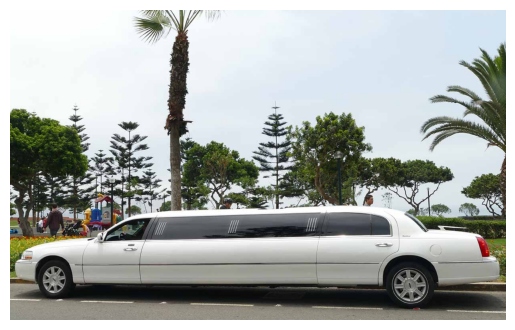

Top 5 Predicted Classes: spider web, spider's web, barn spider, Araneus cavaticus, garden spider, Aranea diademata, black and gold garden spider, Argiope aurantia, wolf spider, hunting spider


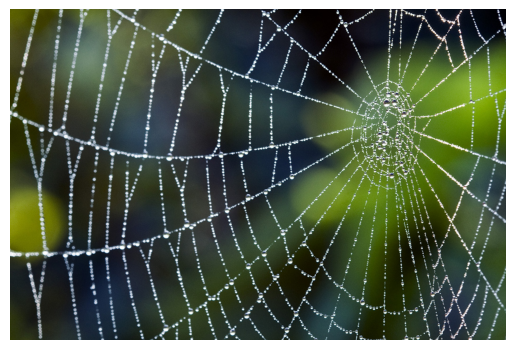

Top 5 Predicted Classes: burrito, guacamole, hotdog, hot dog, red hot, cheeseburger, plate


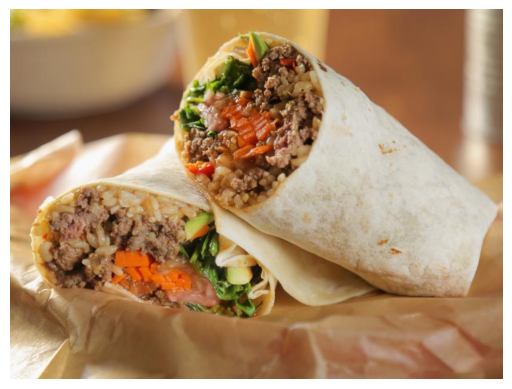

Top 5 Predicted Classes: basketball, rugby ball, volleyball, puck, hockey puck, soccer ball


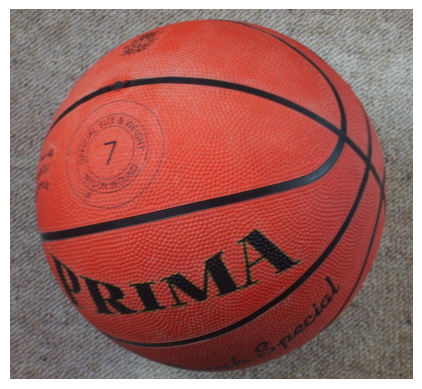

Top 5 Predicted Classes: German shepherd, German shepherd dog, German police dog, alsatian, malinois, kelpie, dingo, warrigal, warragal, Canis dingo, Tibetan mastiff


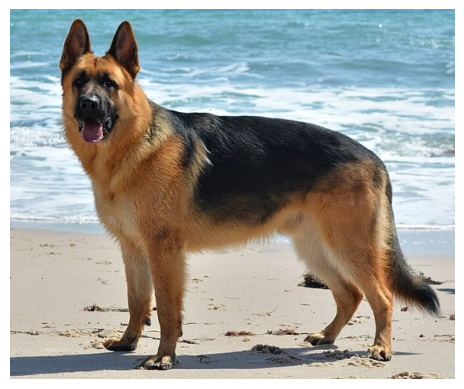

Top 5 Predicted Classes: ice lolly, lolly, lollipop, popsicle, torch, plastic bag, beer glass, paintbrush


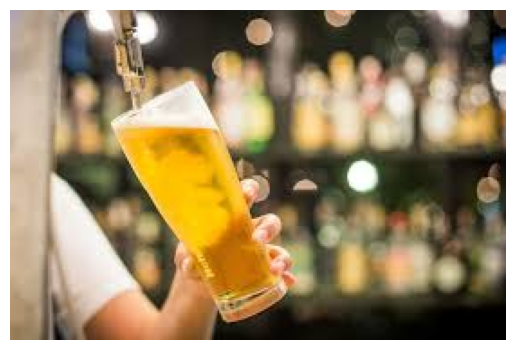

Top 5 Predicted Classes: Christmas stocking, mitten, purse, sock, wool, woolen, woollen


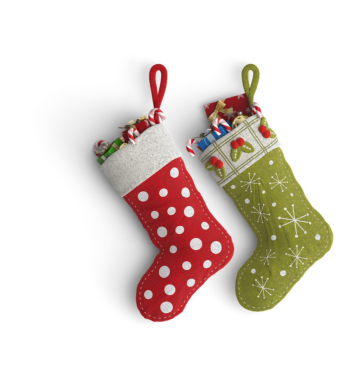

Top 5 Predicted Classes: doormat, welcome mat, bath towel, wool, woolen, woollen, wallet, billfold, notecase, pocketbook, pencil box, pencil case


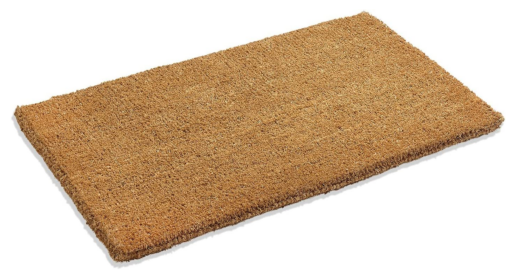

Ground Truth 0: ['collie']
Predicted 0: ['collie', 'Shetland sheepdog, Shetland sheep dog, Shetland', 'papillon', 'Border collie', 'Pomeranian']
Ground Truth 1: ['limousine', 'limo']
Predicted 1: ['limousine, limo', 'minivan', 'convertible', 'grille, radiator grille', 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon']
Ground Truth 2: ['spider web', "spider's web"]
Predicted 2: ["spider web, spider's web", 'barn spider, Araneus cavaticus', 'garden spider, Aranea diademata', 'black and gold garden spider, Argiope aurantia', 'wolf spider, hunting spider']
Ground Truth 3: ['burrito']
Predicted 3: ['burrito', 'guacamole', 'hotdog, hot dog, red hot', 'cheeseburger', 'plate']
Ground Truth 4: ['basketball']
Predicted 4: ['basketball', 'rugby ball', 'volleyball', 'puck, hockey puck', 'soccer ball']
Ground Truth 5: ['german shepherd', 'german shepherd dog', 'german police dog', 'alsatian']
Predicted 5: ['German shepherd, German shepherd dog, German police dog,

'Rank-5 Accuracy = 88.89%'

In [159]:
getRankN(model,'/content/images/class1', ground_truth, N=5)

# Get Rank-1 Accuracy

Top 1 Predicted Classes: collie


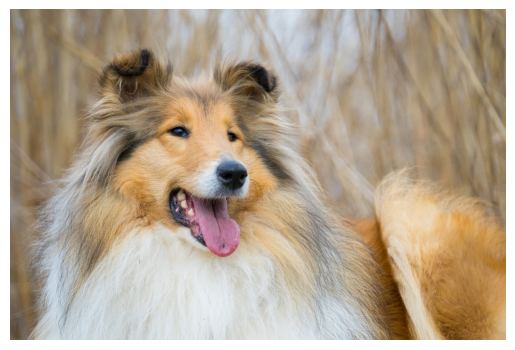

Top 1 Predicted Classes: limousine, limo


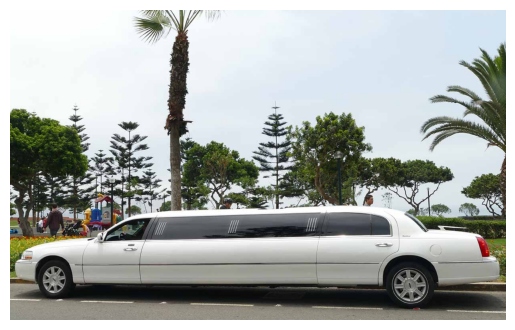

Top 1 Predicted Classes: spider web, spider's web


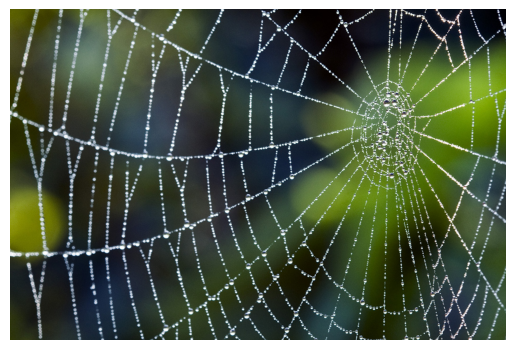

Top 1 Predicted Classes: burrito


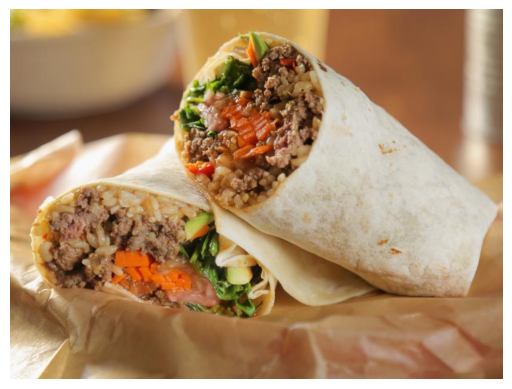

Top 1 Predicted Classes: basketball


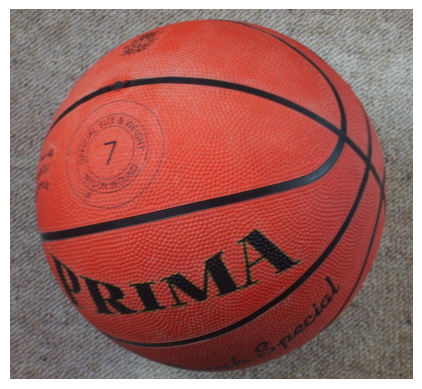

Top 1 Predicted Classes: German shepherd, German shepherd dog, German police dog, alsatian


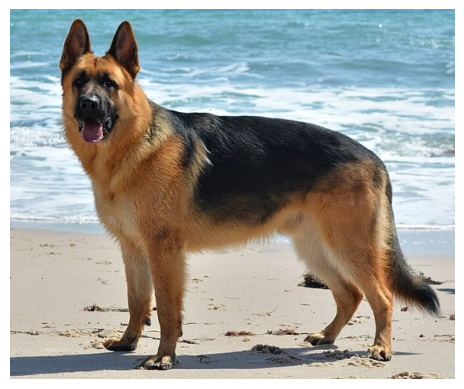

Top 1 Predicted Classes: ice lolly, lolly, lollipop, popsicle


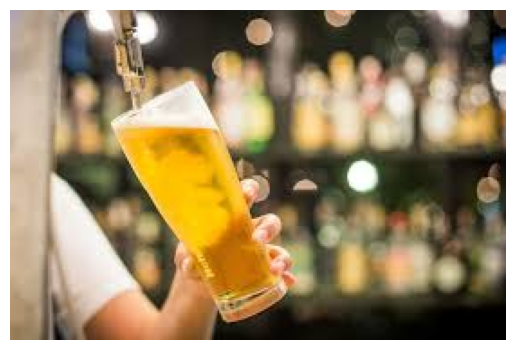

Top 1 Predicted Classes: Christmas stocking


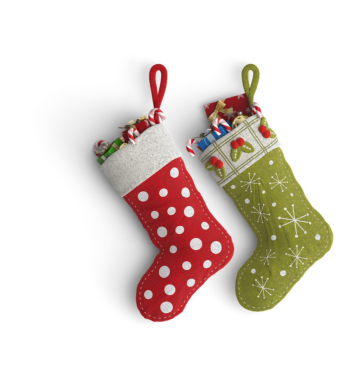

Top 1 Predicted Classes: doormat, welcome mat


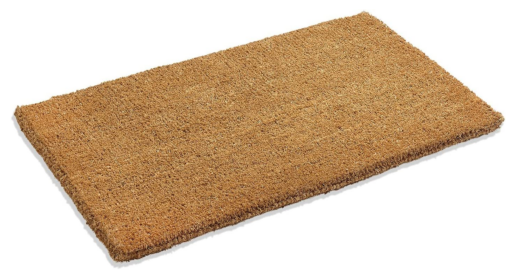

Ground Truth 0: ['collie']
Predicted 0: ['collie']
Ground Truth 1: ['limousine', 'limo']
Predicted 1: ['limousine, limo']
Ground Truth 2: ['spider web', "spider's web"]
Predicted 2: ["spider web, spider's web"]
Ground Truth 3: ['burrito']
Predicted 3: ['burrito']
Ground Truth 4: ['basketball']
Predicted 4: ['basketball']
Ground Truth 5: ['german shepherd', 'german shepherd dog', 'german police dog', 'alsatian']
Predicted 5: ['German shepherd, German shepherd dog, German police dog, alsatian']
Ground Truth 6: ['beer_glass']
Predicted 6: ['ice lolly, lolly, lollipop, popsicle']
Ground Truth 7: ['christmas stocking']
Predicted 7: ['Christmas stocking']
Ground Truth 8: ['doormat', 'welcome mat']
Predicted 8: ['doormat, welcome mat']


'Rank-1 Accuracy = 88.89%'

In [160]:
getRankN(model,'/content/images/class1', ground_truth, N=1)

# Get Rank-10 Accuracy

Top 10 Predicted Classes: collie, Shetland sheepdog, Shetland sheep dog, Shetland, papillon, Border collie, Pomeranian, Pembroke, Pembroke Welsh corgi, red fox, Vulpes vulpes, Australian terrier, borzoi, Russian wolfhound, Eskimo dog, husky


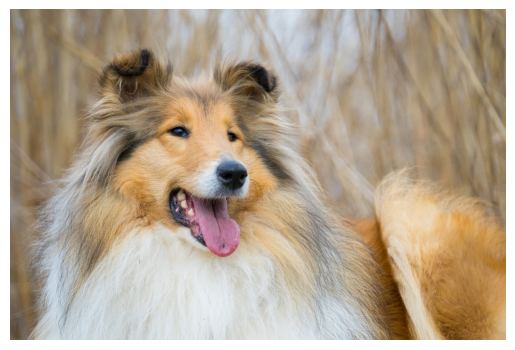

Top 10 Predicted Classes: limousine, limo, minivan, convertible, grille, radiator grille, beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon, car wheel, pickup, pickup truck, sports car, sport car, parking meter, tow truck, tow car, wrecker


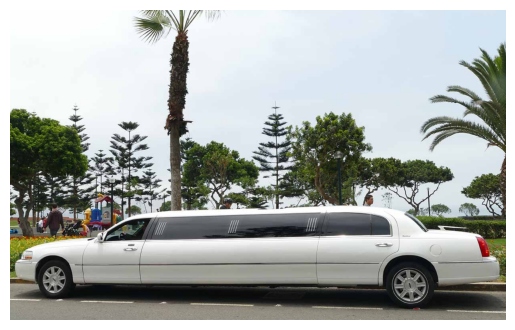

Top 10 Predicted Classes: spider web, spider's web, barn spider, Araneus cavaticus, garden spider, Aranea diademata, black and gold garden spider, Argiope aurantia, wolf spider, hunting spider, black widow, Latrodectus mactans, chainlink fence, window screen, chain, bubble


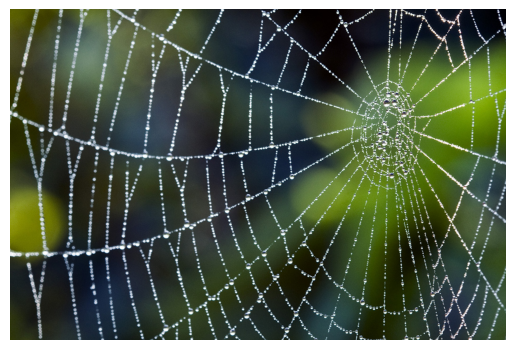

Top 10 Predicted Classes: burrito, guacamole, hotdog, hot dog, red hot, cheeseburger, plate, potpie, French loaf, bagel, beigel, pizza, pizza pie, dough


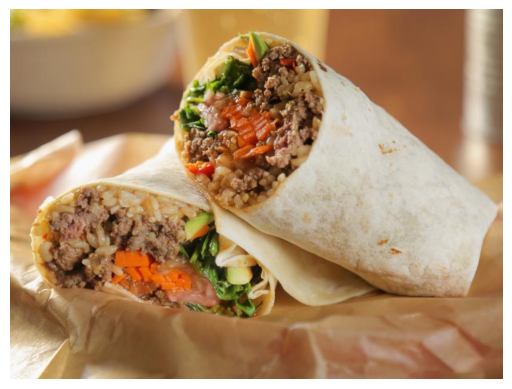

Top 10 Predicted Classes: basketball, rugby ball, volleyball, puck, hockey puck, soccer ball, ping-pong ball, doormat, welcome mat, bottlecap, tennis ball, racket, racquet


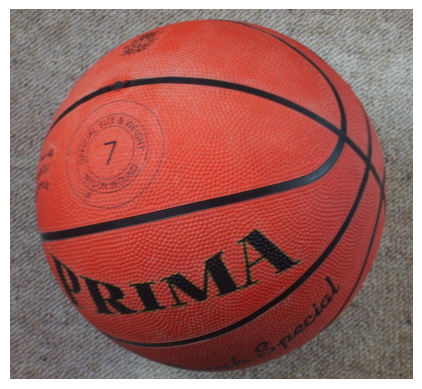

Top 10 Predicted Classes: German shepherd, German shepherd dog, German police dog, alsatian, malinois, kelpie, dingo, warrigal, warragal, Canis dingo, Tibetan mastiff, Norwegian elkhound, elkhound, Rottweiler, Eskimo dog, husky, Australian terrier, Leonberg


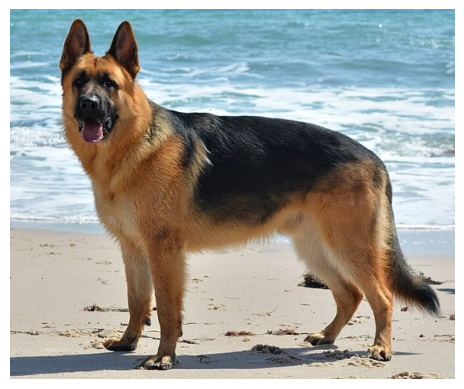

Top 10 Predicted Classes: ice lolly, lolly, lollipop, popsicle, torch, plastic bag, beer glass, paintbrush, beaker, umbrella, pinwheel, packet, bucket, pail


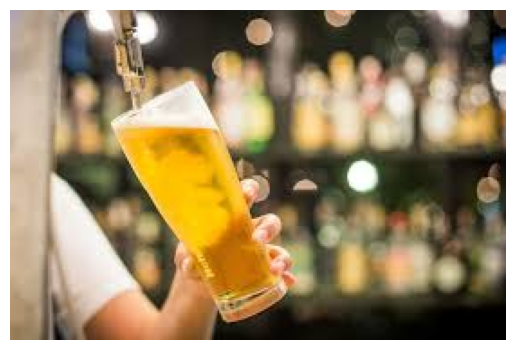

Top 10 Predicted Classes: Christmas stocking, mitten, purse, sock, wool, woolen, woollen, pencil box, pencil case, mailbag, postbag, safety pin, apron, necklace


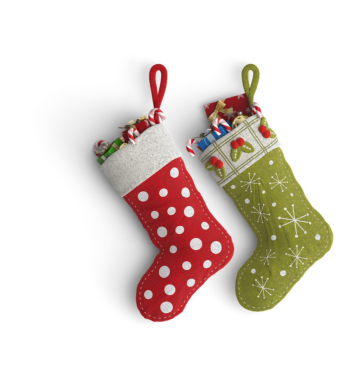

Top 10 Predicted Classes: doormat, welcome mat, bath towel, wool, woolen, woollen, wallet, billfold, notecase, pocketbook, pencil box, pencil case, face powder, thatch, thatched roof, Band Aid, purse, velvet


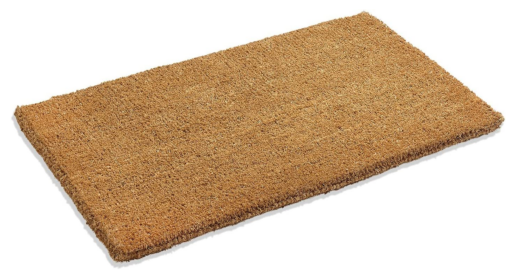

Ground Truth 0: ['collie']
Predicted 0: ['collie', 'Shetland sheepdog, Shetland sheep dog, Shetland', 'papillon', 'Border collie', 'Pomeranian', 'Pembroke, Pembroke Welsh corgi', 'red fox, Vulpes vulpes', 'Australian terrier', 'borzoi, Russian wolfhound', 'Eskimo dog, husky']
Ground Truth 1: ['limousine', 'limo']
Predicted 1: ['limousine, limo', 'minivan', 'convertible', 'grille, radiator grille', 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon', 'car wheel', 'pickup, pickup truck', 'sports car, sport car', 'parking meter', 'tow truck, tow car, wrecker']
Ground Truth 2: ['spider web', "spider's web"]
Predicted 2: ["spider web, spider's web", 'barn spider, Araneus cavaticus', 'garden spider, Aranea diademata', 'black and gold garden spider, Argiope aurantia', 'wolf spider, hunting spider', 'black widow, Latrodectus mactans', 'chainlink fence', 'window screen', 'chain', 'bubble']
Ground Truth 3: ['burrito']
Predicted 3: ['burrito', 'guacamole', 'hotdo

'Rank-10 Accuracy = 88.89%'

In [161]:
getRankN(model,'/content/images/class1', ground_truth, N=10)